In [3]:
import os
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

In [4]:
# Define a model client
model_client = OpenAIChatCompletionClient(
    model = "gpt-4o",
    api_key=api_key
)

In [5]:
# Define a simple function tool that the agent can use.
async def get_weather(city: str) -> str:
    """Get the weather for a given city."""
    return f"The waether in {city} is 73 degrees and sunny."

In [6]:
# Define an AssistantAgent with the model, tool, system message and reflection enabled.
# The system message instructs the agent via natural language.
agent = AssistantAgent(
    name = "weather_agent",
    model_client = model_client,
    tools = [get_weather],
    system_message = "You are a helpful assistant.",
    reflect_on_tool_use = True,
    model_client_stream = True, #Enable streaming tokens from the model client.
)

In [7]:
# Run the agent and stream the messages to the console.
async def main() -> None:
    await Console(agent.run_stream(task="What is the waether in New York?"))
    #Close the connection to the model client.
    await model_client.close()

# NOTE: if running this inside a python script you'll need to use asyncio.run(main())
await main()

---------- TextMessage (user) ----------
What is the waether in New York?
---------- ToolCallRequestEvent (weather_agent) ----------
[FunctionCall(id='call_6bZHfKOxLEj18eGFVpsVJzHs', arguments='{"city":"New York"}', name='get_weather')]
---------- ToolCallExecutionEvent (weather_agent) ----------
[FunctionExecutionResult(content='The waether in New York is 73 degrees and sunny.', name='get_weather', call_id='call_6bZHfKOxLEj18eGFVpsVJzHs', is_error=False)]
---------- ModelClientStreamingChunkEvent (weather_agent) ----------
The weather in New York is currently 73 degrees and sunny.


# Multi-Modal Input


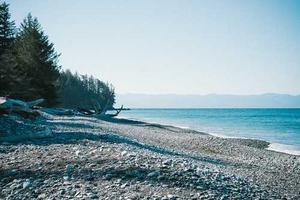

In [20]:
from io import BytesIO

import PIL
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image

#Create a multi-modal message with random image and text.
pil_image = PIL.Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = Image(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="user")
img

In [21]:
# Define an AssistantAgent with the model, tool, system message and reflection enabled.
# The system message instructs the agent via natural language.
agent1 = AssistantAgent(
    name = "multiModal_agent",
    model_client = model_client,
    #tools = [get_weather],
    system_message = "You are a helpful assistant.",
    #reflect_on_tool_use = True,
    #model_client_stream = True, #Enable streaming tokens from the model client.
)

In [23]:
# use asyncio.run(...) when running in a script
result = await agent1.run(task=multi_modal_message)
print(result.messages[-1].content)

This image depicts a tranquil beach scene with a pebble and rocky shoreline extending into a calm body of water. To the left, there are dense clusters of evergreen trees lining the coast. The water is clear and blue, gradually blending into the horizon where distant mountains or hills are faintly visible. The sky above is clear and bright, suggesting a peaceful, sunny day.


# AssistantAgent

In [1]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import StructuredMessage
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

In [11]:
# Define a tool that searches the web for information.
# For simplicity, we will use a mock function here that returns a static string.
async def web_search(query: str) -> str:
    """Find information on web"""
    return "AUtogen is a programming framework for building multi-agent application"

model_client = OpenAIChatCompletionClient(
    model="gpt-4.1-nano",
    api_key=api_key
)

In [12]:
from autogen_core.models import UserMessage
response = await model_client.create([UserMessage(content="Write me a poem", source="user")])
print(response)
#await model_client.close()

finish_reason='stop' content="Certainly! Here's a poem for you:\n\n**Whispers of the Dawn**\n\nAt dawn's first light, the world awakens,\nA canvas soft with hues unspoken.\nDreams linger in the morning air,\nSilent hopes, a whispered prayer.\n\nGentle breezes kiss the leaves,\nSharing secrets the heart treaves.\nSunrise paints the sky anew,\nA promise whispered, bright and true.\n\nStep by step, the day unfolds,\nStories waiting to be told.\nIn every moment, find your song,\nWhere hope and joy belong.\n\nMay your journey be guided bright,\nWith dawn’s embrace and endless light." usage=RequestUsage(prompt_tokens=12, completion_tokens=122) cached=False logprobs=None thought=None


In [18]:
agent2 = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
    reflect_on_tool_use = True,
    model_client_stream = True, #Enable streaming tokens from the model client.
)

In [ ]:
# streaming messages
# Option 1
async def assistant_run_stream() -> None:
    async for message in agent2.run_stream(task="Find information on Autogen"):
        print(message)

In [16]:
await assistant_run_stream()

id='76397f63-7f46-40cd-9141-dec9f37fb26f' source='user' models_usage=None metadata={} created_at=datetime.datetime(2025, 8, 1, 4, 56, 3, 971679, tzinfo=datetime.timezone.utc) content='Find information on Autogen' type='TextMessage'
id='fc80867f-508d-4a89-bef1-1924c3034ad6' source='assistant' models_usage=RequestUsage(prompt_tokens=105, completion_tokens=37) metadata={} created_at=datetime.datetime(2025, 8, 1, 4, 56, 5, 817176, tzinfo=datetime.timezone.utc) content='Autogen is a programming framework designed for building multi-agent applications. It provides tools and structures to facilitate the development and management of autonomous agents that can interact and collaborate within a system.' type='TextMessage'
messages=[TextMessage(id='76397f63-7f46-40cd-9141-dec9f37fb26f', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 8, 1, 4, 56, 3, 971679, tzinfo=datetime.timezone.utc), content='Find information on Autogen', type='TextMessage'), TextMessage(id=

In [19]:
# Option 2: Use Console
await Console(agent2.run_stream(task="Find information on Autogen"), output_stats=True)

---------- TextMessage (user) ----------
Find information on Autogen
---------- ToolCallRequestEvent (assistant) ----------
[FunctionCall(id='call_OFws4PC0PGZw0aLPB9SoWez2', arguments='{"query": "Autogen"}', name='web_search')]
[Prompt tokens: 0, Completion tokens: 0]
---------- ToolCallExecutionEvent (assistant) ----------
[FunctionExecutionResult(content='AUtogen is a programming framework for building multi-agent application', name='web_search', call_id='call_OFws4PC0PGZw0aLPB9SoWez2', is_error=False)]
---------- ModelClientStreamingChunkEvent (assistant) ----------
Autogen is a programming framework designed for building multi-agent applications. It facilitates the development of systems where multiple autonomous agents interact and collaborate to achieve complex goals. If you need more specific information or details about its features and use cases, please let me know!
[Prompt tokens: 0, Completion tokens: 0]
---------- Summary ----------
Number of messages: 4
Finish reason: None

TaskResult(messages=[TextMessage(id='c003f1d5-0fa9-4209-aa0e-51819b7a63e6', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 8, 1, 4, 59, 54, 272936, tzinfo=datetime.timezone.utc), content='Find information on Autogen', type='TextMessage'), ToolCallRequestEvent(id='7a58a612-72db-4837-84a7-02fe9e58f114', source='assistant', models_usage=RequestUsage(prompt_tokens=0, completion_tokens=0), metadata={}, created_at=datetime.datetime(2025, 8, 1, 4, 59, 56, 23295, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='call_OFws4PC0PGZw0aLPB9SoWez2', arguments='{"query": "Autogen"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(id='c2b03752-d113-478b-af5c-eedf7226a1e0', source='assistant', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 8, 1, 4, 59, 56, 64766, tzinfo=datetime.timezone.utc), content=[FunctionExecutionResult(content='AUtogen is a programming framework for building multi-agent application', name='w

# FunctionTool

In [24]:
from autogen_core.tools import FunctionTool

In [25]:
# Define a tool using a python function
async def web_search_func(query: str) -> str:
    """Find information on the web"""
    return "AUtogen is a programming framework for building multi-agent application"

In [27]:
# This step is automatically performed inside AssistantAgent if the tool is a python function.
web_search_function_tool = FunctionTool(web_search_func, description="Find information on the web")
# The schema is provided to the model during AssistantAgent's on_message call.
web_search_function_tool.schema

{'name': 'web_search_func',
 'description': 'Find information on the web',
 'parameters': {'type': 'object',
  'properties': {'query': {'description': 'query',
    'title': 'Query',
    'type': 'string'}},
  'required': ['query'],
  'additionalProperties': False},
 'strict': False}

# Structured Output

In [31]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import StructuredMessage
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

from typing import Literal
from pydantic import BaseModel


In [29]:
# The response message from the agent as a Pydantic base Model.
class AgentResponse(BaseModel):
    thoughts: str
    response: Literal['happy','sad','neutral']

In [32]:
#Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(model="gpt-4o", api_key=api_key)
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    system_message="Categorize the input as happy, sad and neutral following the JSON format.",
    # Define the output content type of the agent
    output_content_type=AgentResponse
)

In [33]:
result = await Console(agent.run_stream(task="I am happy."))

---------- TextMessage (user) ----------
I am happy.
---------- StructuredMessage[AgentResponse] (assistant) ----------
{"thoughts":"The statement directly expresses the user's emotional state as being happy.","response":"happy"}


In [34]:
# Check the last message in the result, validate its type, and print the thoughts and response.
assert isinstance(result.messages[-1], StructuredMessage)
assert isinstance(result.messages[-1].content, AgentResponse)
print("Thought: ", result.messages[-1].content.thoughts)
print("Response: ", result.messages[-1].content.response)
await model_client.close()

Thought:  The statement directly expresses the user's emotional state as being happy.
Response:  happy
